In [353]:
# Продакт-менеджер попросил проанализировать совершенные покупки и ответить на следующие вопросы:
# 1. Сколько у нас пользователей, которые совершили покупку только один раз?  
# 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 
# 3. По каждому товару определить, в какой день недели товар чаще всего покупается.
# 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
# 5. Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту с самым высоким
#    retention на 3й месяц. 
# 6.  Используя python, построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации 
#    использовать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество 
#    покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. 
#    Для каждого RFM-сегмента построить границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [370]:
# Для начала подгрузим необхлдимые библиотеки

In [1]:
import pandas as pd 
import numpy as np 
%matplotlib inline  
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy as scipy 
import plotly.express as px 
from datetime import timedelta
from operator import attrgetter
import warnings
warnings.filterwarnings('ignore')
import requests 
from urllib.parse import urlencode

In [2]:
# Данные предоставили в виде файлов на Яндекс Диске. Выполнение проекта выполняю в Jupyterhub, загружаю файлы и подгружаю их.

In [3]:
olist_c_dataset=pd.read_csv('olist_customers_dataset.csv')

In [4]:
olist_order_items_dataset=pd.read_csv('olist_order_items_dataset.csv')

In [5]:
olist_orders_dataset=pd.read_csv('olist_orders_dataset.csv')

In [6]:
# Фактом покупки считаетаем факт присвоенного order_id

In [7]:
# JOINим таблицы, сначала LEFT таблицы с индификатором заказа и данные пользователя, затем inner с данными по заказам.

In [8]:
olist=olist_orders_dataset.merge(olist_c_dataset, how='left', on='customer_id')

In [9]:
olist.shape

(99441, 12)

In [10]:
olist=olist.merge(olist_order_items_dataset, how='inner', on='order_id')

In [11]:
olist.shape

(112650, 18)

In [14]:
olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [15]:
olist.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_item_id                      int64
product_id                        object
seller_id                         object
shipping_limit_date               object
price                            float64
freight_value                    float64
dtype: object

In [16]:
olist.nunique()

order_id                         98666
customer_id                      98666
order_status                         7
order_purchase_timestamp         98112
order_approved_at                90174
order_delivered_carrier_date     81017
order_delivered_customer_date    95664
order_estimated_delivery_date      450
customer_unique_id               95420
customer_zip_code_prefix         14976
customer_city                     4110
customer_state                      27
order_item_id                       21
product_id                       32951
seller_id                         3095
shipping_limit_date              93318
price                             5968
freight_value                     6999
dtype: int64

In [17]:
olist.isna().sum()
# Кол-во пропусков

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
dtype: int64

In [18]:
olist.groupby("order_id", as_index = False).agg({"order_item_id": "count"}).sort_values("order_item_id", ascending=False)
# Посмотрим кол-во товарных едениц в заказах

,order_id,order_item_id
50137,8272b63d03f5f79c56e9e4120aec44ef,21
10459,1b15974a0141d54e36626dca3fdc731a,20
65715,ab14fdcfbe524636d65ee38360e22ce8,20
60941,9ef13efd6949e4573a18964dd1bbe7f5,15
25583,428a2f660dc84138d969ccd69a0ab6d5,15
...,...,...
34640,5a0911d70c1f85d3bed0df1bf693a6dd,1
34639,5a082b558a3798d3e36d93bfa8ca1eae,1
34637,5a07264682e0b8fbb3f166edbbffc6e8,1
34636,5a071192a28951b76774e5a760c8c9b7,1


In [19]:
# Ответим на вопрос: 1. Сколько у нас пользователей, которые совершили покупку только один раз?  

In [20]:
olist.groupby('customer_unique_id', as_index=False) \
.agg({'order_id': 'nunique'}) \
.query('order_id=="1"')

,customer_unique_id,order_id
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1
95416,fffea47cd6d3cc0a88bd621562a9d061,1
95417,ffff371b4d645b6ecea244b27531430a,1
95418,ffff5962728ec6157033ef9805bacc48,1


In [21]:
 # Ответ: 92507 покупатель совершил покупку только один раз

In [22]:
# Ответим на вопрос: 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? 

# Решение: Создаём столбец с месяцами на основании столбца с обещанной даты доставки. Переводим его в формат дата.
           # Создаем дф исключая заказы со статусом доставлено.
           # Создаем дф группируя по месяцам и причинам, по которым не доставляется товар. Суммируем.
           # Распределяем колонки более удобно для работы
           # Считаем среднее по месяцам

In [227]:
olist['month']=pd.to_datetime(olist["order_estimated_delivery_date"]).dt.month

In [228]:
olist_query_or_s=olist.query('order_status!="delivered"')

In [229]:
olist_query_or_s.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month,day_w,week_in_month
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00,36edbb3fb164b1f16485364b6fb04c73,98900,...,RS,1,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,2017-04-19 13:25:17,49.90,16.05,5,Thursday,4.285714
46,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00,08fb46d35bb3ab4037202c23592d1259,13215,...,SP,1,c50ca07e9e4db9ea5011f06802c0aea0,e9779976487b77c6d4ac45f75ec7afe9,2018-06-13 04:30:33,14.49,7.87,6,Tuesday,4.285714
118,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00,c7f8d7b1fffc946d7069574f74c39f4e,88140,...,SC,1,1522589c64efd46731d3522568e5bc83,28405831a29823802aa22c084cfd0649,2018-08-13 06:15:14,35.00,15.35,8,Tuesday,4.428571
148,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00,9f269af9c49244f6ba4a46985a3cfc2e,3436,...,SP,1,61d52f4882421048afd530db53d6f230,fa74b2f3287d296e9fbd2cc80f2d1cf1,2017-09-20 14:30:09,125.90,12.38,10,Sunday,4.285714
185,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00,528b011eb7fab3d59c336cc7248eed3a,38600,...,MG,1,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,2018-01-18 02:32:30,53.99,15.13,2,Thursday,4.428571


In [230]:
olist_query_or_s.groupby("order_status", as_index = False).agg({"customer_id": "count"})

,order_status,customer_id
0,approved,3
1,canceled,542
2,invoiced,359
3,processing,357
4,shipped,1185
5,unavailable,7


In [231]:
olist_or_st_count=olist_query_or_s.groupby(['month','order_status'])['order_status'].agg(['count']).reset_index()

In [232]:
olist_or_st_count.head()

,month,order_status,count
0,1,canceled,6
1,1,invoiced,15
2,1,processing,29
3,1,shipped,56
4,2,canceled,32


In [233]:
olist_z2_otvet=olist_or_st_count.pivot(index='month', columns='order_status', values='count')

In [234]:
olist_z2_otvet=olist_z2_otvet.fillna(0)

In [235]:
olist_z2_otvet['mean']=(olist_z2_otvet.approved+olist_z2_otvet.canceled+olist_z2_otvet.invoiced+olist_z2_otvet.processing+olist_z2_otvet.shipped+olist_z2_otvet.unavailable)/6

In [236]:
olist_z2_otvet # Ответ

order_status,approved,canceled,invoiced,processing,shipped,unavailable,mean
month,,,,,,,
1,0.0,6.0,15.0,29.0,56.0,0.0,17.666667
2,0.0,32.0,14.0,43.0,68.0,0.0,26.166667
3,2.0,115.0,39.0,50.0,141.0,0.0,57.833333
4,0.0,30.0,34.0,45.0,171.0,0.0,46.666667
5,1.0,53.0,32.0,18.0,188.0,0.0,48.666667
6,0.0,42.0,42.0,28.0,92.0,0.0,34.000000
7,0.0,49.0,14.0,19.0,109.0,0.0,31.833333
8,0.0,103.0,47.0,16.0,141.0,0.0,51.166667
9,0.0,24.0,23.0,20.0,56.0,0.0,20.500000


In [237]:
# Ответим на вопрос: 3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)
      
    # Решение. На основании колонки подтверждения даты оплаты создаем колонку "дни недели" и переводим в формат дата.
    # Создаем новый дф группируя по id продукта.

In [34]:
olist['day_w']=pd.to_datetime(olist['order_approved_at']).dt.day_name()

In [35]:
olist_day=olist.groupby('product_id', as_index=False) \
.agg({'day_w': pd.Series.mode})

In [36]:
olist_day # Ответ

,product_id,day_w
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday
1,00088930e925c41fd95ebfe695fd2655,Tuesday
2,0009406fd7479715e4bef61dd91f2462,Friday
3,000b8f95fcb9e0096488278317764d19,"[Friday, Wednesday]"
4,000d9be29b5207b54e86aa1b1ac54872,Tuesday
...,...,...
32946,fff6177642830a9a94a0f2cba5e476d1,"[Monday, Saturday]"
32947,fff81cc3158d2725c0655ab9ba0f712c,Monday
32948,fff9553ac224cec9d15d49f5a263411f,Saturday
32949,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday


In [37]:
# Ответим на вопрос: 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? 
    
    # Решение.Создаем дополнительный столбец с кол-вом недель в месяце.
    # Создаем дф группируя по пользователям и месяцам.
    # Добавляем новый столбец со средним кол-вом покупок в неделю.

In [38]:
olist['week_in_month']=pd.to_datetime(olist['order_approved_at']).dt.daysinmonth/7

In [39]:
olist_mean=olist.groupby(['customer_id', 'month','week_in_month'], as_index=False) \
.agg({'order_id':'nunique'})

In [40]:
olist_mean['mean_month']=olist_mean.order_id/olist_mean.week_in_month

In [41]:
olist_mean # Ответ

,customer_id,month,week_in_month,order_id,mean_month
0,00012a2ce6f8dcda20d059ce98491703,12,4.285714,1,0.233333
1,000161a058600d5901f007fab4c27140,8,4.428571,1,0.225806
2,0001fd6190edaaf884bcaf3d49edf079,3,4.000000,1,0.250000
3,0002414f95344307404f0ace7a26f1d5,9,4.428571,1,0.225806
4,000379cdec625522490c315e70c7a9fb,4,4.285714,1,0.233333
...,...,...,...,...,...
98647,fffcb937e9dd47a13f05ecb8290f4d3e,4,4.428571,1,0.225806
98648,fffecc9f79fd8c764f843e9951b11341,4,4.428571,1,0.225806
98649,fffeda5b6d849fbd39689bb92087f431,6,4.428571,1,0.225806
98650,ffff42319e9b2d713724ae527742af25,6,4.285714,1,0.233333


In [280]:
# Ответим на вопрос: 5.Используя pandas, провести когортный анализ пользователей. В период с января по декабрь выявить когорту 
                     # с самым высоким retention на 3й месяц.
    
 # Решение: 
            # Привожу основную таблицу к более удобному формату.
           # Расчетный период беру 2017г. согласно задания.     
            # Создаю дф и первой датой покупки

In [301]:
olist=for_kogort

In [302]:
for_kogort.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,month,day_w,week_in_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,10,Monday,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,8,Thursday,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,9,Wednesday,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,12,Saturday,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,2,Tuesday,4.000000


In [303]:
for_kogort_new['order_approved_at']=olist.order_approved_at.astype('datetime64[M]')

In [304]:
for_kogort_new.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,product_id,seller_id,shipping_limit_date,price,freight_value,month,day_w,week_in_month,first_orders,first_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-01,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,...,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,10,Monday,4.428571,NaT,2017-09-01
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-01,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,8,Thursday,4.428571,NaT,2018-07-01
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-01,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,9,Wednesday,4.428571,NaT,2018-08-01
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-01,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,...,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,12,Saturday,4.285714,NaT,2017-11-01
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-01,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,2,Tuesday,4.000000,NaT,2018-02-01


In [306]:
for_kogort_new['first_order'] = for_kogort_new.groupby('customer_unique_id')['order_approved_at'].transform('min')
# Дата первой покупки

In [308]:
orders_merged=for_kogort_new.query("'01-01-2017' <= first_order <= '31-12-2017'")\
.groupby(['first_order', 'order_approved_at'],as_index=False).agg({'customer_unique_id': 'nunique'})
# Определяю необходимый период и уникальных пользователей

In [312]:
orders_merged.first_order = pd.to_datetime(orders_merged.first_order).dt.to_period("m")
orders_merged.order_approved_at = pd.to_datetime(orders_merged.order_approved_at).dt.to_period("m")
# Привели к формату месяц

In [313]:
orders_merged['diff'] = (orders_merged.order_approved_at - orders_merged.first_order).apply(attrgetter("n"))
# Создаю колонку время существования когорты

In [314]:
orders_merged

,first_order,order_approved_at,customer_unique_id,diff
0,2017-01,2017-01,718,0
1,2017-01,2017-02,4,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
166,2017-12,2018-04,13,4
167,2017-12,2018-05,11,5
168,2017-12,2018-06,9,6
169,2017-12,2018-07,1,7


In [315]:
orders_merged_otvet = orders_merged.pivot(index='first_order', columns = 'diff', values = 'customer_unique_id')


In [316]:
orders_merged_otvet.head()

diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,718.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0,5.0,3.0,1.0,1.0,2.0,3.0,1.0
2017-02,1689.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,5.0,2.0,3.0,2.0,1.0,1.0,4.0,NaN
2017-03,2604.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,10.0,3.0,6.0,3.0,4.0,6.0,2.0,4.0,NaN
2017-04,2314.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,4.0,5.0,2.0,2.0,1.0,2.0,2.0,4.0,NaN,NaN
2017-05,3561.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,9.0,10.0,10.0,12.0,7.0,2.0,7.0,9.0,NaN,NaN,NaN


In [317]:
retention = orders_merged_otvet.div(orders_merged_otvet.iloc[:,0], axis = 0)
final_table = (retention
            .style
            .set_caption('Retention by cohort')  # добавляем подпись
            .background_gradient(cmap='viridis')  # раскрашиваем ячейки по столбцам
            .highlight_null('white')  # делаем белый фон для значений NaN
            .format("{:.2%}", na_rep="0"))  # числа форматируем как проценты, NaN заменяем на пустоту
         
final_table

diff,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
first_order,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.56%,0.28%,0.14%,0.42%,0.14%,0.42%,0.14%,0.14%,0,0.28%,0.28%,0.70%,0.42%,0.14%,0.14%,0.28%,0.42%,0.14%
2017-02,100.00%,0.24%,0.24%,0.18%,0.41%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,0
2017-03,100.00%,0.50%,0.35%,0.35%,0.35%,0.15%,0.15%,0.31%,0.31%,0.12%,0.38%,0.12%,0.23%,0.12%,0.15%,0.23%,0.08%,0.15%,0
2017-04,100.00%,0.61%,0.22%,0.17%,0.30%,0.26%,0.35%,0.26%,0.35%,0.17%,0.22%,0.09%,0.09%,0.04%,0.09%,0.09%,0.17%,0,0
2017-05,100.00%,0.53%,0.48%,0.39%,0.31%,0.34%,0.42%,0.14%,0.25%,0.28%,0.28%,0.34%,0.20%,0.06%,0.20%,0.25%,0,0,0
2017-06,100.00%,0.48%,0.35%,0.38%,0.26%,0.35%,0.38%,0.22%,0.13%,0.22%,0.32%,0.38%,0.16%,0.13%,0.19%,0,0,0,0
2017-07,100.00%,0.53%,0.34%,0.18%,0.34%,0.18%,0.32%,0.11%,0.18%,0.24%,0.21%,0.29%,0.13%,0.26%,0,0,0,0,0
2017-08,100.00%,0.67%,0.36%,0.26%,0.38%,0.53%,0.26%,0.26%,0.12%,0.17%,0.24%,0.17%,0.12%,0,0,0,0,0,0
2017-09,100.00%,0.66%,0.49%,0.34%,0.41%,0.27%,0.22%,0.22%,0.32%,0.17%,0.27%,0.07%,0,0,0,0,0,0,0


In [318]:
retention[2].idxmax(axis= 1)
# Когорта с самым высоким retention на 3й месяц.

Period('2017-09', 'M')

In [ ]:
# Ответим на вопрос: 6. Используя python, построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
  # В кластеризации можешь выбрать следующиеметрики: R - время от последней покупки пользователя до текущей даты, F - суммарное
  # количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.
  # Для каждого RFM-сегмента построить границы  метрик recency, frequency и monetary для интерпретации этих кластеров. 

In [ ]:
# Находим временные рамки данных и кол-во дней в периоде.

In [12]:
olist.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [13]:
full_table = olist.dropna()  

In [14]:
full_table['order_approved_at']=pd.to_datetime(full_table['order_approved_at'])

In [15]:
full_table.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


In [16]:
print('Orders from {} to {}'.format(full_table['order_approved_at'].min(),
                                    full_table['order_approved_at'].max()))

Orders from 2016-09-15 12:16:38 to 2018-08-29 15:10:26


In [17]:
print('Orders from {} '.format([full_table['order_approved_at'].max()-
                                    full_table['order_approved_at'].min()]))

Orders from [Timedelta('713 days 02:53:48')] 


In [18]:
#orders = full_table.groupby(['order_id', 'order_approved_at', 'customer_unique_id'])['price'].agg(['sum']).reset_index()

In [19]:
NOW = full_table['order_approved_at'].max() + timedelta(days=1)
NOW

Timestamp('2018-08-30 15:10:26')

In [20]:
full_table['DaysSinceOrder'] = full_table['order_approved_at'].apply(lambda x: (NOW - x).days)

In [21]:
period= 718

In [22]:
aggr = {
    'DaysSinceOrder': lambda x: x.min(),  # количество дней с момента последнего заказа (Recency)
    'order_approved_at': lambda x: len([d for d in x if d >= NOW - timedelta(days=period)]), # общее количество заказов за последний период (Frequency)
}
rfm = full_table.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'DaysSinceOrder': 'Recency', 'order_approved_at': 'Frequency'}, inplace=True)
rfm

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1
2,0000f46a3911fa3c0805444483337064,537,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,1
4,0004aac84e0df4da2b147fca70cf8255,288,1
...,...,...,...
93337,fffcf5a5ff07b0908bd4e2dbc735a684,447,2
93338,fffea47cd6d3cc0a88bd621562a9d061,262,1
93339,ffff371b4d645b6ecea244b27531430a,568,1
93340,ffff5962728ec6157033ef9805bacc48,119,1


In [23]:
olist_o=full_table.groupby('customer_unique_id')['price'].agg(['count','sum']).reset_index()

In [24]:
agg_mer=rfm.merge(olist_o, how='outer', on='customer_unique_id')

In [25]:
agg_mer['date']=full_table['order_approved_at']

In [26]:
agg_mer.rename(columns={'sum': 'Monetary'}, inplace=True)

In [27]:
agg_mer.head()

,customer_unique_id,Recency,Frequency,count,Monetary,date
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,1,129.90,2017-10-02 11:07:15
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,1,18.90,2018-07-26 03:24:27
2,0000f46a3911fa3c0805444483337064,537,1,1,69.00,2018-08-08 08:55:23
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,1,25.99,2017-11-18 19:45:59
4,0004aac84e0df4da2b147fca70cf8255,288,1,1,180.00,2018-02-13 22:20:29


In [28]:
quintiles = agg_mer[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.5, 0.75]).to_dict()
quintiles

{'Recency': {0.25: 114.0, 0.5: 219.0, 0.75: 346.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 47.65, 0.5: 89.7, 0.75: 154.69}}

In [29]:
def r_score(x):
    if x <= quintiles['Recency'][0.25]:
        return 3
    elif x <= quintiles['Recency'][0.5]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][0.25]:
        return 1
    elif x <= quintiles[c][0.5]:
        return 2
    else:
        return 3    

In [30]:
agg_mer['R'] = agg_mer['Recency'].apply(lambda x: r_score(x))
agg_mer['F'] = agg_mer['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
agg_mer['M'] = agg_mer['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [31]:
agg_mer['RFM Score'] = agg_mer['R'].map(str) + agg_mer['F'].map(str) + agg_mer['M'].map(str)
agg_mer.head()

,customer_unique_id,Recency,Frequency,count,Monetary,date,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,1,129.90,2017-10-02 11:07:15,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,1,18.90,2018-07-26 03:24:27,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,1,69.00,2018-08-08 08:55:23,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,1,25.99,2017-11-18 19:45:59,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,288,1,1,180.00,2018-02-13 22:20:29,1,1,3,113


In [33]:
# Сегменты
# 'about to sleep' - Покупали очень давно и совершили только 1 покупку
# 'at risk' - Покупали давно, но большой обьем
# 'loyal1' - Покупали сравнительно недавно 1 покупка
# 'loyal2' - Покупали сравнительно недавно , более одной покупки
# 'loyal3' - Покупали недавно, но 1 покупку
# 'resent' - Покупали недавно,более одной покупки
# 'champ' - Покупали недавно и много

In [34]:
segt_map = {
    r'11': 'about to sleep',
    r'13': 'at risk',
    r'21': 'loyal1',
    r'22': 'loyal2',
    r'23': 'loyal3',
    r'31': 'resent',
    r'33': 'champ'
    
}

agg_mer['Segment'] = agg_mer['R'].map(str) + agg_mer['F'].map(str)
agg_mer['Segment'] = agg_mer['Segment'].replace(segt_map, regex=True)
agg_mer.head()

,customer_unique_id,Recency,Frequency,count,Monetary,date,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,1,129.90,2017-10-02 11:07:15,3,1,3,313,resent
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,1,18.90,2018-07-26 03:24:27,3,1,1,311,resent
2,0000f46a3911fa3c0805444483337064,537,1,1,69.00,2018-08-08 08:55:23,1,1,2,112,about to sleep
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,1,25.99,2017-11-18 19:45:59,1,1,1,111,about to sleep
4,0004aac84e0df4da2b147fca70cf8255,288,1,1,180.00,2018-02-13 22:20:29,1,1,3,113,about to sleep


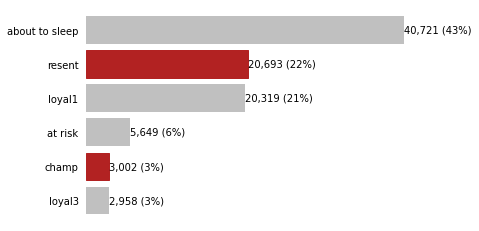

In [35]:
segments_counts = agg_mer['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champ', 'resent']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()
#  Группа "loyal2-покупки сравнительно недавно более 1" не отображается, т.к. при дальнейшей проверке  равны 0, 
# из начальных расчетов сегмент удалять не стала.